# How to properly train a neural network (using PyTorch)
1. Data exploration
2. Setting up a dataset and dataloader
3. Creating a simple neural network model
4. Choosing the right parameters for the model (learning rate finder, gradient monitoring)

To explore how properely train a neural network, we first need a dataset. For this script, I have decided to use a dataset of Chest X-Ray Images for which we should classify whether the patient suffers from pneumonia or not. The dataset is freely available [here](https://data.mendeley.com/datasets/rscbjbr9sj/2) by Kermany et al. (2018). After downloading the data from the above provided Kaggle link, unpack the dataset and place it in "./datasets/chest_xray". 

This is what your directory structure should look like:

```
/how_to_properly_train_a_nn.ipynb
/datasets (not included in repo)
┣ 📂 chest_xray
┃   ┣ 📂 train
┃   ┃   ┣ 📂 NORMAL
┃   ┃   ┣ 📂 PNEUMONIA
┃   ┣ 📂 test
┃   ┃   ┣ 📂 NORMAL
┃   ┃   ┣ 📂 PNEUMONIA
```

1. Data exploration

Before going to the exciting modeling part, we should always(!) check the data first. Thereby, we can get a feel for what the data looks like and what input our model can expect, but also look for some common data-related problems that may occur, like
- nan values in the data
- unequal class distributions (e.g. having more patient than healthy data)

In [1]:
#Let's first make some imports of all the libraries that we will use in this project
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import Compose, Resize, ToTensor
from torcheval.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
#Let's check how many samples we have in each class for training and testing
n_train_normal = len(os.listdir('../datasets/chest_xray/train/NORMAL'))
n_train_pneumonia = len(os.listdir('../datasets/chest_xray/train/PNEUMONIA'))
n_test_normal = len(os.listdir('../datasets/chest_xray/test/NORMAL'))
n_test_pneumonia = len(os.listdir('../datasets/chest_xray/test/PNEUMONIA'))

# Create a DataFrame
data = {
    "train": [n_train_normal, n_train_pneumonia],
    "test": [n_test_normal, n_test_pneumonia]
}

index = ["NORMAL", "PNEUMONIA"]

df = pd.DataFrame(data, index=index)

df

,train,test
NORMAL,1349,234
PNEUMONIA,3883,390


Note that we have $\frac{3884}{1349}=2.88$ more PNEUMONIA than NORMAL samples in the training data. Class imbalance is mainly treated in 3 different ways:
- Random under-sampling of majority class
- Random over-sampling of minority class
- Data augmentation

We will try a blend of those methods

In [5]:
img_list = os.listdir('../datasets/chest_xray/train/NORMAL')
train_paths, val_paths = train_test_split(img_list, test_size=0.15, random_state=42)
len(train_paths), len(val_paths)

(1146, 203)

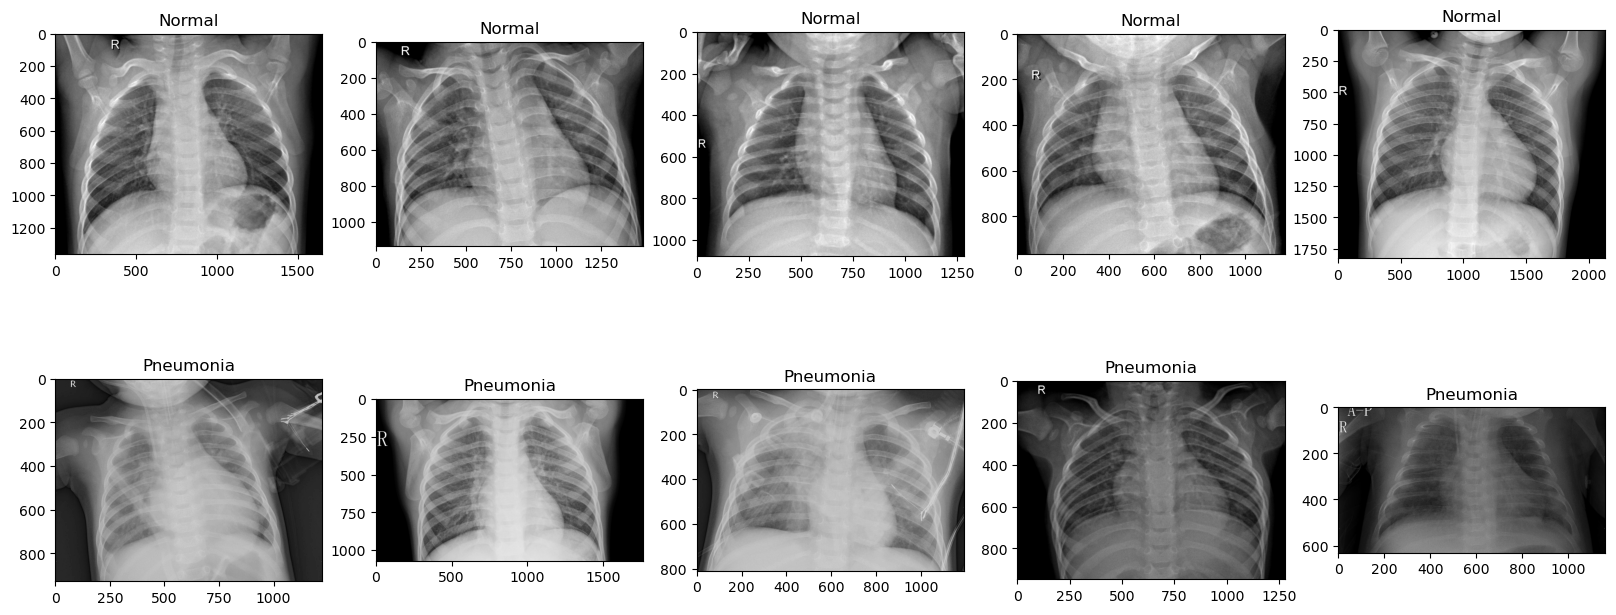

Minimum pixel value: 0
Maximum pixel value: 255


In [6]:
#Let's visualize 5 random normal vs 5 pneumonia images

norm_idxs = np.random.choice(n_train_normal, 5, replace=False)
pneu_idxs = np.random.choice(n_train_pneumonia, 5, replace=False)

norm_list = os.listdir('../datasets/chest_xray/train/NORMAL')
pneu_list = os.listdir('../datasets/chest_xray/train/PNEUMONIA')

plt.figure(figsize=(20,8))
idx_count = 1
for idx in norm_idxs:
    plt.subplot(2,5,idx_count) #n_rows, n_columns, index
    img = plt.imread('../datasets/chest_xray/train/NORMAL/' + norm_list[idx])
    plt.imshow(img, cmap='gray')
    plt.title('Normal')
    idx_count += 1

for idx in pneu_idxs:
    plt.subplot(2,5,idx_count)
    img = plt.imread('../datasets/chest_xray/train/PNEUMONIA/' + pneu_list[idx])
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    idx_count += 1

plt.show()

print(f"Minimum pixel value: {np.min(img)}")
print(f"Maximum pixel value: {np.max(img)}")

Notice that the images have different sizes. That means we need to take care of this by transforming them into the same size [224, 224]. As a positive side effect that also means we can stack all images into one tensor.

Additionally, we can see that the pixel values lie between [0, 255]. For better convergence and to improve numerical stability, we will normalize the data input range to [-1, 1]. 

Because some of the PNEUMONIA images have 3 channels (RGB --> 3, Height, Width), we will read all images as grayscale images.

In [ ]:
class NormalizeImage(torch.nn.Module):
    """
    Normalizes the image to be in the range [-1, 1].
    """
    def __init__(self):
        super().__init__()

    def forward(self, image):
        return image / 255 * 2.0 - 1.0


def preprocess_image(transforms, split="train", seed=42):
    """
    Preprocesses images, splits train into train/val, and saves as tensors.

    Args:
        transforms: A torchvision.transforms.Compose object with transformations.
        split: 'train' or 'test' dataset.
        seed: Random seed for reproducibility.
    """

    assert split in ["train", "test"], "split must be either 'train' or 'test'"
    image_path = f'./datasets/chest_xray/{split}/'

    # Organize image paths by condition (NORMAL, PNEUMONIA)
    image_paths = {
        "NORMAL":  os.listdir(image_path + 'NORMAL'),
        "PNEUMONIA": os.listdir(image_path + 'PNEUMONIA')
    }

    if split == "train":
        train_paths, val_paths = {}, {}
        for condition, paths in image_paths.items():
            train_paths[condition], val_paths[condition] = train_test_split(paths, test_size=0.15, random_state=seed)

        # Preprocess and store train data
        images_train = [transforms(read_image(path=os.path.join(image_path, condition, path), mode=ImageReadMode.GRAY))
                        for condition, paths in train_paths.items() for path in paths]
        out_train = torch.stack(images_train)
        labels_train = torch.cat([torch.zeros(len(train_paths['NORMAL'])), 
                                  torch.ones(len(train_paths['PNEUMONIA']))])

        # Preprocess and store validation data 
        images_val = [transforms(read_image(path=os.path.join(image_path, condition, path), mode=ImageReadMode.GRAY))
                      for condition, paths in val_paths.items() for path in paths]
        out_val = torch.stack(images_val)
        labels_val = torch.cat([torch.zeros(len(val_paths['NORMAL'])), 
                                torch.ones(len(val_paths['PNEUMONIA']))])

        # Save train/val data and labels
        torch.save(out_train, f'../datasets/chest_xray/train_data.pt')
        torch.save(labels_train, f'../datasets/chest_xray/train_labels.pt')
        torch.save(out_val, f'../datasets/chest_xray/val_data.pt')
        torch.save(labels_val, f'../datasets/chest_xray/val_labels.pt')

        #Sanity Checks
        print(f"Train data shape: {out_train.shape}")
        print(f"Train labels shape: {labels_train.shape}")
        print(f"Val data shape: {out_val.shape}")
        print(f"Val labels shape: {labels_val.shape}")

    else:  # Test set
        images = [transforms(read_image(path=os.path.join(image_path, condition, path), mode=ImageReadMode.GRAY))
                  for condition, paths in image_paths.items() for path in paths]
        out = torch.stack(images)
        labels = torch.cat([torch.zeros(len(image_paths['NORMAL'])), 
                            torch.ones(len(image_paths['PNEUMONIA']))])

        # Save test data and labels
        torch.save(out, f'../datasets/chest_xray/test_data.pt')
        torch.save(labels, f'../datasets/chest_xray/test_labels.pt')

        #Sanity Checks
        print(f"Test data shape: {out.shape}")
        print(f"Test labels shape: {labels.shape}")
    


transforms = Compose([
    NormalizeImage(),
    Resize((224, 224)),
    ])

preprocess_image(transforms, split="train")
preprocess_image(transforms, split="test")

2. Setting up a dataset and dataloader
Then, we can continue by creating a [Dataset and Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

To take care of the class imbalance we calculate a weight for each sample that depends on the frequency of its class. These weights are passed to the WeightedRandomSampler, leading to oversampling of the minority class and undersampling of the majority class.
Therefore, in one epoch the model might not see all samples, but as we randomly select new ones each epoch, our model will see most samples during training.

In [4]:
#Time to make a Dataset

class XRay_Dataset(Dataset):

    def __init__(self, split="train"):
        super().__init__()
        assert split in ["train", "val", "test"], "split must be either 'train' or 'test'"

        self.data = torch.load(f'../datasets/chest_xray/{split}_data.pt')
        self.labels = torch.load(f'../datasets/chest_xray/{split}_labels.pt')

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx,...]
        label = self.labels[idx]
        return image, label


def calculate_weights(labels):
    """
    Calculates weights for each class based on the frequency of each class in the dataset.

    Args:
        labels: A tensor containing the labels (e.g. train_dataset.labels).

    Returns:
        A tensor containing the weights for each sample
    """
    n_norm, n_pneu = labels.unique(return_counts=True)[1]
    n_total = len(labels)

    weight_norm = n_pneu/n_total
    weight_pneu = n_norm/n_total

    weights = torch.cat([torch.ones(n_norm)*weight_norm, torch.ones(n_pneu)*weight_pneu])
    return weights

#Create dataset
train_dataset = XRay_Dataset(split="train")
val_dataset = XRay_Dataset(split="val")

#Calculate weights
train_weights = calculate_weights(train_dataset.labels)

#Create sampler
train_sampler = WeightedRandomSampler(train_weights, len(train_dataset), replacement=True)

# #and a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler = train_sampler)
val_dataloader = DataLoader(val_dataset, batch_size=64)

3. Creating a simple (convolutional) neural network model

If you are new to creating a PyTorch **model**, see [here](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html).

For the basics of how to write a **training loop**, you may refer to [this](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html). However, we will use a **Learner** class which combines the essentials of the training loop in one class.

In [9]:
train_dataset.__getitem__(0)[0].shape

torch.Size([1, 224, 224])

In [10]:
#First, let's build a simple CNN
class SimpleModel(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=6, stride=3, padding=1)
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=6, stride=3, padding=1)
        self.dropout = torch.nn.Dropout(0.5)
        self.bn1 = torch.nn.BatchNorm2d(8)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3, stride=3)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x) #[BS, 32, 112, 112]
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = self.conv2(x) #[BS, 64, 28, 28]
        x = self.bn2(x)
        x = self.relu(x)
        x = self.max_pool(x)
        #print(x.shape)
        x = self.dropout(x)
        x = x.view(x.size(0), -1) #[BS, 128]
        x = self.fc(x) #[BS, 1]
        x = torch.squeeze(x) 
        x = torch.sigmoid(x)
        return x

def fit(model, train_loader, val_loader, optimizer, loss_fn, n_epochs):
    """
    Takes in a model, a dataloader, an optimizer, a loss function, and trains the model for n_epochs.
    """
    for epoch in range(n_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = []
        val_acc = []
        for data in train_loader:
            x, y = data
            optimizer.zero_grad() #zero the gradients (otherwise they accumulate)
            preds = model(x) #make predictions (forward pass)
            loss = loss_fn(preds, y) #calculate the loss
            loss.backward() #calculate the gradients
            optimizer.step() #adjust the weights
            train_loss += loss.item()
            train_acc.append(torch.round(preds).eq(y).sum().item()/len(y))

        with torch.no_grad():
            for data in val_loader:
                x, y = data
                preds = model(x)
                loss = loss_fn(preds, y)
                val_loss += loss.item()
                val_acc.append(torch.round(preds).eq(y).sum().item()/len(y))

        print(f"Epoch {epoch+1}")
        print(f"Training loss: {train_loss/len(train_loader):.3f}, Training accuracy: {np.mean(train_acc):.3f}") 
        print(f"Validation loss: {val_loss/len(val_loader):.3f}, Validation accuracy: {np.mean(val_acc):.3f}")
        train_loss = 0.0
        val_loss = 0.0
        train_acc = []
        val_acc = []

#Instantiate the model, loss function, and optimizer
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, 5)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "c:\Users\s_gue\anaconda3\envs\vision\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "c:\Users\s_gue\anaconda3\envs\vision\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
#Now, we can create a Learner
class Learner():
    def __init__(self, model, training_loader, validation_loader, loss_fn, optimizer, lr):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.loss_fn = loss_fn
        self.lr = lr
        self.optimizer = optimizer(self.model.parameters(), lr=self.lr)
        
    def fit(self, n_epochs):
        self.accuracy, self.loss = [], []
        self.model.to(self.device) #move model to device
        for epoch in range(n_epochs):
            print(f"Epoch {epoch+1}/{n_epochs}")
            self.model.train()

    def one_batch(self, batch):
        x, y = batch
        preds = self.model(x)
        loss = self.loss_fn(preds, y)
        if self.train:
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        self.loss.append(loss.item())

    def one_epoch(self, train):
        if train:
        for batch in self.training_loader:
            self.one_batch(batch)

In [2]:
import numpy as np

a = 12
b = 10

np.remainder(a, b)

2

In [6]:
model = SimpleModel()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_number = 0
EPOCHS = 5
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, train_dataloader, every_n_batches=False)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

EPOCH 1:


ValueError: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 256, 14, 14])) is deprecated. Please ensure they have the same size.

Note: We use the $F1= \frac{2*(Recall + Precision)}{Recall + Precision}$ score as metric as it does not ignore class imbalance as accuracy does (e.g. if we have a dataset with class-ratios of 99:1, then our model have almost perfect accuracy by always predicting the majority class).

Remember:

$Recall = \frac{True Positives}{True Positives + False Negatives}$ and $Precision=\frac{True Positives}{True Positives + False Positives}$

In [17]:
labels = torch.load(f'./datasets/chest_xray/test_labels.pt')
norm, pneu = labels.unique(return_counts=True)[1]

In [18]:
norm

tensor(234)

Things to improve code:
- use fc.store_attr() instead of assigning the passed values one by one to each class parameter


# References
Kermany, D. S., Goldbaum, M., Cai, W., Valentim, C. C. S., Liang, H., Baxter, S. L., McKeown, A., Yang, G., Wu, X., Yan, F., Dong, J., Prasadha, M. K., Pei, J., Ting, M. Y. L., Zhu, J., Li, C., Hewett, S., Dong, J., Ziyar, I., … Zhang, K. (2018). Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell, 172(5), 1122-1131.e9. https://doi.org/10.1016/j.cell.2018.02.010